In [1]:
# Install necessary packages
#!pip install cupy-cuda12x 

# Import libraries
import pandas as pd
import numpy as np
import random
from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction, AlgoBase, SlopeOne, KNNBasic
from surprise.model_selection import train_test_split, cross_validate, KFold
import torch
from tqdm.notebook import tqdm
from surprise import SVD, SVDpp, NMF, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings  # Added this line

# Set random seed for reproducibility
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

# Load the ratings data
ratings_df = pd.read_csv('anime_ratings.csv') # Changed filename

In [2]:
# Randomly pick 5% of users (or adjust as needed for the new dataset size)
all_users = ratings_df['user_id'].unique()
# Consider adjusting the sample size based on the new dataset's user count
sample_size = int(0.05 * len(all_users)) 
if sample_size == 0 and len(all_users) > 0: # Ensure at least one user if possible
    sample_size = 1 
elif len(all_users) == 0:
    raise ValueError("The loaded CSV file contains no users.")
    
sampled_users = np.random.choice(all_users, size=sample_size, replace=False)

# Filter ratings to keep only the sampled users
ratings_sampled = ratings_df[ratings_df['user_id'].isin(sampled_users)]

# Further sample data for efficiency if needed (adjust n based on new dataset size)
# Example: Sample up to 35000 ratings, or all if fewer exist
n_sample_ratings = min(35000, len(ratings_sampled))
if n_sample_ratings > 0:
    ratings_filtered_sample = ratings_sampled.sample(n=n_sample_ratings, random_state=my_seed)
else:
    # Handle case where sampled users have no ratings (unlikely but possible)
    ratings_filtered_sample = ratings_sampled # Keep the empty dataframe
    print("Warning: No ratings found for the sampled users.")

In [3]:
# Define the scale of ratings (using the sampled data)
# Check if ratings_sampled is empty before calculating min/max
if not ratings_sampled.empty:
    min_rating = ratings_sampled['rating'].min()
    max_rating = ratings_sampled['rating'].max()
else:
    # Default scale if no ratings were sampled (e.g., 1 to 10)
    min_rating = 1
    max_rating = 10 
    print("Warning: Using default rating scale (1-10) as no ratings were sampled.")

# Create a Surprise Reader object
reader = Reader(rating_scale=(min_rating, max_rating))

# Load the data into Surprise format (using the potentially further sampled data)
# Check if ratings_filtered_sample is empty before loading
if not ratings_filtered_sample.empty:
    anime_data = Dataset.load_from_df(ratings_filtered_sample[['user_id', 'anime_id', 'rating']], reader)
else:
    # Handle the case where there's no data to load
    anime_data = None
    print("Error: No data available to load into Surprise Dataset.")

In [4]:
# Split into training and testing sets (80% train, 20% test)
# testset here is a list of tuples (user_id, item_id, rating)
# Only proceed if anime_data was successfully created
if anime_data:
    trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed)
else:
    trainset, testset = None, [] # Assign None/empty list if no data
    print("Skipping train/test split as there is no data.")

# Baseline

In [5]:
# Global Mean Baseline
class GlobalMeanBaseline(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
    
    def estimate(self, u, i):
        # Handle case where trainset might be None
        if not self.trainset:
            return 0 # Or some other default
        return self.trainset.global_mean
    
    def fit(self, trainset):
        # Handle case where trainset might be None
        if not trainset:
            self.trainset = None
            print("Warning: Cannot fit GlobalMeanBaseline with no trainset.")
            return self
        AlgoBase.fit(self, trainset)
        return self

# Popular Items Baseline (already implemented in the RecSys project)
class PopularBaseline(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        self.mean_rating_per_item_df = pd.DataFrame(columns=['rating'])
        self.global_mean_fallback = 0
    
    def estimate(self, u, i):
        # Handle case where trainset might be None
        if not self.trainset:
            return self.global_mean_fallback
            
        # Convert inner item id to raw item id
        try:
            raw_iid = self.trainset.to_raw_iid(i)
        except ValueError:
            # Item not in trainset, return global mean
            return self.trainset.global_mean

        if raw_iid in self.mean_rating_per_item_df.index:
            return self.mean_rating_per_item_df.loc[raw_iid]['rating']
        else:
            # Item was in trainset but somehow not in mean ratings (shouldn't happen with current fit)
            # Or if mean_rating_per_item_df is empty
            return self.trainset.global_mean
    
    def fit(self, trainset):
        # Handle case where trainset might be None
        if not trainset:
            self.trainset = None
            self.mean_rating_per_item_df = pd.DataFrame(columns=['rating'])
            self.global_mean_fallback = 0
            print("Warning: Cannot fit PopularBaseline with no trainset.")
            return self
            
        AlgoBase.fit(self, trainset)
        self.global_mean_fallback = self.trainset.global_mean
        
        # Use raw ids directly from all_ratings()
        # Check if trainset has ratings
        all_ratings_list = list(self.trainset.all_ratings())
        if not all_ratings_list:
             self.mean_rating_per_item_df = pd.DataFrame(columns=['rating'])
             print("Warning: Trainset has no ratings for PopularBaseline.")
             return self
             
        ratings_df = pd.DataFrame([[self.trainset.to_raw_iid(i), r] 
                                   for (_, i, r) in all_ratings_list],
                                  columns=['item', 'rating'])
        
        self.mean_rating_per_item_df = (
            ratings_df
            .groupby('item')
            .agg({'rating': 'mean'})
        )
        
        return self

In [6]:
# Only run baselines if trainset and testset exist and are not empty
if trainset and testset:
    # Create baseline models
    global_mean_baseline = GlobalMeanBaseline()
    popular_baseline = PopularBaseline()
    
    # Train the baseline models
    global_mean_baseline.fit(trainset)
    popular_baseline.fit(trainset)
    
    # Make predictions
    global_predictions = global_mean_baseline.test(testset)
    popular_predictions = popular_baseline.test(testset)
    
    # Evaluate baseline performance
    print("Global Mean Baseline RMSE:", accuracy.rmse(global_predictions))
    print("Popular Items Baseline RMSE:", accuracy.rmse(popular_predictions))
else:
    print("Skipping baseline evaluation due to lack of data.")
    global_predictions = []
    popular_predictions = []

RMSE: 1.4624
Global Mean Baseline RMSE: 1.4623974041652252
RMSE: 1.6374
Popular Items Baseline RMSE: 1.6374155022537646


# Ensamble Model

In [7]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    # Check if there's actually a CUDA device
    try:
        print(f"GPU Device: {torch.cuda.get_device_name(0)}")
        device = torch.device("cuda")
    except Exception as e:
        print(f"CUDA reported available, but got error: {e}. Falling back to CPU.")
        cuda_available = False # Correct the flag
        device = torch.device("cpu")
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA Available: True
GPU Device: NVIDIA GeForce RTX 4090


In [8]:
# Define a function to create base models
def create_base_models(random_state=my_seed):
    models = {
        # Model-based CF approaches
        'SVD': SVD(random_state=random_state),
        'SVDpp': SVDpp(random_state=random_state),
        'NMF': NMF(random_state=random_state),
        
        # Memory-based CF approaches
        'KNN_Basic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}),
        'KNN_Means': KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False}),
        'KNN_ZScore': KNNWithZScore(sim_options={'name': 'pearson', 'user_based': False}),
        
        # User-based approaches
        'User_KNN_Basic': KNNBasic(sim_options={'name': 'cosine', 'user_based': True}),
        'User_KNN_Means': KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
    }
    return models

# Create base models
base_models = create_base_models()

In [9]:
# Function to train models and get predictions
def train_and_predict(models, trainset, testset):
    all_predictions = {}
    all_models = {}
    
    # Check if trainset and testset are valid
    if not trainset or not testset:
        print("Skipping model training and prediction due to lack of data.")
        return all_predictions, all_models
        
    print("Training base models and collecting predictions...")
    for name, model in tqdm(models.items(), desc="Training Models"):
        # Train the model
        start_time = time.time()
        try:
            model.fit(trainset)
        except Exception as e:
            print(f"Error fitting model {name}: {e}. Skipping this model.")
            all_predictions[name] = []
            all_models[name] = None
            continue # Skip to the next model
        train_time = time.time() - start_time
        
        # Make predictions on the testset (list of tuples)
        start_time = time.time()
        try:
            # The .test() method can handle the list of tuples directly
            predictions = model.test(testset)
        except Exception as e:
             print(f"Error predicting with model {name}: {e}. Skipping predictions for this model.")
             predictions = [] # Assign empty list on error
        predict_time = time.time() - start_time
        
        # Store predictions (list of Prediction objects) and trained model
        all_predictions[name] = predictions
        all_models[name] = model
        
        # Calculate RMSE if predictions were made
        if predictions:
            try:
                rmse = accuracy.rmse(predictions)
                print(f"{name}: RMSE = {rmse:.4f}, Train Time = {train_time:.2f}s, Predict Time = {predict_time:.2f}s")
            except Exception as e:
                print(f"Error calculating RMSE for {name}: {e}")
        else:
             print(f"{name}: No predictions generated. Train Time = {train_time:.2f}s, Predict Time = {predict_time:.2f}s")
    
    return all_predictions, all_models

# Train models and get predictions (using the potentially None/empty trainset/testset)
all_predictions, all_models = train_and_predict(base_models, trainset, testset)

Training base models and collecting predictions...


Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

RMSE: 1.3402
SVD: RMSE = 1.3402, Train Time = 0.01s, Predict Time = 0.00s
RMSE: 1.3324
SVDpp: RMSE = 1.3324, Train Time = 0.06s, Predict Time = 0.01s
RMSE: 2.4928
NMF: RMSE = 2.4928, Train Time = 0.06s, Predict Time = 0.00s
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4784
KNN_Basic: RMSE = 1.4784, Train Time = 0.04s, Predict Time = 0.01s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6425
KNN_Means: RMSE = 1.6425, Train Time = 0.06s, Predict Time = 0.01s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6443
KNN_ZScore: RMSE = 1.6443, Train Time = 0.05s, Predict Time = 0.01s
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.5292
User_KNN_Basic: RMSE = 1.5292, Train Time = 0.00s, Predict Time = 0.00s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4876
User_KNN_Means: RMSE = 1.4876, Train Time = 0.00s, Pre

In [10]:
# Create a meta-dataset for stacking
# FIX: Modified function to handle testset as list of (uid, iid, r_ui) tuples
def create_meta_dataset(all_predictions, testset_tuples):
    # Check if input is valid
    if not all_predictions or not testset_tuples:
        print("Cannot create meta-dataset: No predictions or testset tuples provided.")
        return pd.DataFrame() # Return empty DataFrame
        
    # Create a dictionary to store all predictions
    meta_data = {}
    valid_models = list(all_predictions.keys())
    
    # Organize predictions by user-item pair using the Prediction objects
    for model_name, predictions in all_predictions.items():
        if not predictions: # Skip models that failed to produce predictions
            print(f"Skipping model {model_name} in meta-dataset creation (no predictions).")
            if model_name in valid_models:
                 valid_models.remove(model_name)
            continue
            
        for pred in predictions: # pred is a surprise.Prediction object
            user = pred.uid
            item = pred.iid
            rating = pred.r_ui # Actual rating from the original data
            estimated = pred.est # Prediction from this base model
            
            key = (user, item)
            
            if key not in meta_data:
                meta_data[key] = {
                    'actual': rating,
                    'predictions': {}
                }
            
            meta_data[key]['predictions'][model_name] = estimated
    
    # Convert to DataFrame, ensuring alignment with the original testset_tuples
    rows = []
    # Create a set of keys from the input testset_tuples for quick lookup
    # FIX: Iterate through testset_tuples directly, which are (uid, iid, r_ui)
    testset_keys = set([(uid, iid) for uid, iid, r_ui in testset_tuples])

    # Iterate through the testset_tuples to maintain order and ensure all original test points are considered
    processed_keys = set() # Keep track of keys added to avoid duplicates if any exist in testset_tuples
    for uid, iid, r_ui_actual in testset_tuples:
        key = (uid, iid)
        if key in meta_data and key not in processed_keys: # Check if we have predictions for this key
            data = meta_data[key]
            # Double check the actual rating matches (should usually be the case)
            # assert data['actual'] == r_ui_actual, f"Mismatch in actual rating for key {key}"
            row = {'user': key[0], 'item': key[1], 'actual': r_ui_actual} # Use actual from testset_tuples
            
            all_models_present = True
            # Only check against models that successfully produced predictions
            for model_name in valid_models: 
                if model_name not in data['predictions']:
                    # This case means a base model failed to predict for this item
                    # We might skip this row or fill with a default (e.g., global mean)
                    # Skipping is safer for meta-model training
                    # print(f"Warning: Missing prediction for {model_name} on {key}. Skipping row.")
                    all_models_present = False
                    break 
                row[model_name] = data['predictions'][model_name]
                
            if all_models_present:
               rows.append(row)
               processed_keys.add(key)

    meta_df = pd.DataFrame(rows)
    # Reorder columns to have 'user', 'item', 'actual' first, then model predictions
    if not meta_df.empty:
        # Use only the models that had predictions
        cols = ['user', 'item', 'actual'] + valid_models 
        meta_df = meta_df[cols]
    return meta_df

# Create meta dataset using the predictions and the original testset tuples
print("Creating meta-dataset for stacking...")
# FIX: Pass the original 'testset' (list of tuples) directly
meta_df = create_meta_dataset(all_predictions, testset)

if not meta_df.empty:
    print(f"Meta-dataset shape: {meta_df.shape}")
    display(meta_df.head()) # Use display for better notebook output
else:
    print("Meta-dataset is empty.")

Creating meta-dataset for stacking...
Meta-dataset shape: (334, 11)


,user,item,actual,SVD,SVDpp,NMF,KNN_Basic,KNN_Means,KNN_ZScore,User_KNN_Basic,User_KNN_Means
0,28294,10793,7.0,7.463710,7.453892,4.218778,7.920599,8.000000,8.000000,7.920599,7.470588
1,913,16498,9.0,8.274053,8.448763,4.735756,7.920599,8.500000,8.500000,7.920599,9.000000
2,6969,31519,7.0,8.570569,8.570684,7.920599,7.920599,7.920599,7.920599,7.920599,7.920599
3,29314,13601,7.0,7.848712,7.736491,3.211336,7.920599,9.000000,9.000000,7.920599,5.000000
4,19963,28619,7.0,7.721397,7.669628,7.920599,7.920599,7.920599,7.920599,7.920599,7.920599


In [11]:
# Initialize meta_results dictionary
meta_results = {}

# Only proceed if meta_df is not empty
if not meta_df.empty:
    # Create training data for meta-model
    # Ensure only columns corresponding to successful base models are used
    feature_cols = [col for col in meta_df.columns if col not in ['user', 'item', 'actual']]
    if not feature_cols:
        print("Error: No feature columns (base model predictions) found in meta_df.")
        X, y = pd.DataFrame(), pd.Series() # Assign empty
    else:
        X = meta_df[feature_cols]
        y = meta_df['actual']

    # Split into training and validation sets only if X and y are not empty
    if not X.empty and not y.empty:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=my_seed)
    else:
        print("Skipping train/val split for meta-models due to lack of features or target.")
        X_train, X_val, y_train, y_val = [None]*4 # Assign None

    # Define meta-models
    meta_models = {
        'Simple_Average': None,  # We'll implement this differently
        'Weighted_Average': None,  # We'll implement this differently
        'Linear_Regression': LinearRegression(),
        'Ridge_Regression': Ridge(alpha=1.0),
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, max_depth=10, random_state=my_seed,
            n_jobs=-1 if not cuda_available else 1  # Use all CPU cores if GPU not available
        ),
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100, learning_rate=0.1, random_state=my_seed
        )
    }

    # Train and evaluate meta-models only if train/val data exists
    if X_train is not None and X_val is not None:
        print("Training meta-models...")
        # Get the list of base models that actually produced predictions
        successful_base_models = list(X_train.columns)
        
        for name, model in tqdm(meta_models.items(), desc="Training Meta-Models"):
            if name == 'Simple_Average':
                # Simple average prediction
                if not X_val.empty:
                    preds = X_val.mean(axis=1)
                    rmse_val = np.sqrt(mean_squared_error(y_val, preds))
                else:
                    preds = pd.Series()
                    rmse_val = float('inf')
                meta_results[name] = {
                    'model': None,
                    'predictions': preds,
                    'rmse': rmse_val
                }
            
            elif name == 'Weighted_Average':
                # Weighted average based on individual model RMSE on the test set
                weights = {}
                total_inv_rmse = 0
                valid_weights_calculated = False
                # Use only successful base models for weighting
                for model_name in successful_base_models:
                    # Calculate RMSE on the full test set predictions stored earlier
                    # Check if predictions exist for this model
                    if model_name in all_predictions and all_predictions[model_name]:
                        try:
                            rmse = accuracy.rmse(all_predictions[model_name], verbose=False) # Use stored predictions
                            # Inverse weighting - lower RMSE gets higher weight
                            # Add a small epsilon to avoid division by zero if RMSE is somehow 0
                            inv_rmse = 1 / (rmse + 1e-9)
                            weights[model_name] = inv_rmse
                            total_inv_rmse += inv_rmse
                            valid_weights_calculated = True # Mark that at least one weight was calculated
                        except Exception as e:
                            print(f"Could not calculate RMSE for {model_name} for weighted avg: {e}")
                            weights[model_name] = 0 # Assign zero weight if RMSE calculation fails
                    else:
                         weights[model_name] = 0 # Assign zero weight if no predictions
                
                # Normalize weights if any valid weights were calculated
                if valid_weights_calculated and total_inv_rmse > 0:
                    weights = {k: v / total_inv_rmse for k, v in weights.items()}
                else: # Fallback: equal weights if no valid RMSEs found
                     num_models = len(successful_base_models)
                     if num_models > 0:
                         equal_weight = 1.0 / num_models
                         weights = {k: equal_weight for k in successful_base_models}
                     else:
                         weights = {}
                
                # Apply weights to the validation set predictions (X_val)
                if not X_val.empty and weights:
                    weighted_preds = np.zeros(len(X_val))
                    for model_name, weight in weights.items():
                        if model_name in X_val.columns: # Ensure column exists
                             weighted_preds += X_val[model_name].values * weight
                    rmse_val = np.sqrt(mean_squared_error(y_val, weighted_preds))
                else:
                    weighted_preds = np.array([])
                    rmse_val = float('inf')
                
                meta_results[name] = {
                    'model': weights, # Store the calculated weights
                    'predictions': weighted_preds,
                    'rmse': rmse_val
                }
            
            else: # Other sklearn models
                try:
                    # Train the model
                    model.fit(X_train, y_train)
                    
                    # Make predictions
                    if not X_val.empty:
                        preds = model.predict(X_val)
                        rmse_val = np.sqrt(mean_squared_error(y_val, preds))
                    else:
                        preds = np.array([])
                        rmse_val = float('inf')
                    
                    # Store results
                    meta_results[name] = {
                        'model': model,
                        'predictions': preds,
                        'rmse': rmse_val
                    }
                except Exception as e:
                    print(f"Error training/predicting meta-model {name}: {e}")
                    meta_results[name] = {'model': None, 'predictions': np.array([]), 'rmse': float('inf')}
            
            # Print RMSE only if it's not infinity
            current_rmse = meta_results[name]['rmse']
            if current_rmse != float('inf'):
                 print(f"{name}: RMSE = {current_rmse:.4f}")
            else:
                 print(f"{name}: Could not calculate RMSE.")
    else:
        print("Skipping meta-model training and evaluation due to lack of data.")
else:
    print("Skipping meta-model steps as meta_df is empty.")
    X_train, X_val, y_train, y_val = [None]*4 # Ensure these are None if meta_df was empty

Training meta-models...


Training Meta-Models:   0%|          | 0/6 [00:00<?, ?it/s]

Simple_Average: RMSE = 1.4112
Weighted_Average: RMSE = 1.3848
Linear_Regression: RMSE = 1.3334
Ridge_Regression: RMSE = 1.3319
Random_Forest: RMSE = 1.3929
Gradient_Boosting: RMSE = 1.4684


In [12]:
# Only attempt NN ensemble if CUDA is available AND training data exists
if cuda_available and X_train is not None and y_train is not None and X_val is not None and y_val is not None:
    print("Building GPU-accelerated ensemble...")
    
    # Define a simple neural network meta-model
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    
    class EnsembleNet(nn.Module):
        def __init__(self, input_size):
            super(EnsembleNet, self).__init__()
            # Ensure input_size is at least 1
            if input_size < 1:
                raise ValueError(f"Input size for NN must be at least 1, got {input_size}")
            self.layers = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 1)
            )
        
        def forward(self, x):
            return self.layers(x)
    
    # Convert data to PyTorch tensors
    try:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1).to(device)
    except Exception as e:
        print(f"Error converting data to tensors: {e}. Skipping NN.")
        # Skip the rest of the NN block if conversion fails
        cuda_available = False # Effectively disable NN part

    # Proceed only if tensor conversion was successful
    if 'X_train_tensor' in locals(): 
        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        # Ensure batch size is not larger than dataset size
        batch_size = min(128, len(train_dataset))
        if batch_size == 0:
             print("Training dataset for NN is empty. Skipping NN training.")
             cuda_available = False # Disable NN part
        else:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
            # Initialize model
            input_size = X_train.shape[1]
            try:
                model = EnsembleNet(input_size).to(device)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            except ValueError as e:
                 print(f"Error initializing NN model: {e}. Skipping NN.")
                 cuda_available = False # Disable NN part

    # Proceed only if model initialization was successful
    if cuda_available and 'model' in locals() and 'train_loader' in locals():
        # Training loop
        epochs = 50
        best_val_rmse = float('inf')
        best_model_state = None
        final_val_preds = np.array([]) # Initialize
        final_val_rmse = float('inf')

        try:
            for epoch in tqdm(range(epochs), desc="Training NN Ensemble"):
                model.train()
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                
                # Evaluate on validation set
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    val_loss = criterion(val_outputs, y_val_tensor)
                    
                    # Convert back to CPU for RMSE calculation
                    val_preds = val_outputs.cpu().numpy().flatten()
                    val_actual = y_val_tensor.cpu().numpy().flatten()
                    val_rmse = np.sqrt(mean_squared_error(val_actual, val_preds))
                    
                    if (epoch + 1) % 10 == 0:
                        print(f"Epoch {epoch+1}/{epochs}: Loss = {val_loss:.4f}, RMSE = {val_rmse:.4f}")
                    
                    # Save the best model based on validation RMSE
                    if val_rmse < best_val_rmse:
                        best_val_rmse = val_rmse
                        best_model_state = model.state_dict()

            # Load the best model state
            if best_model_state:
                model.load_state_dict(best_model_state)
                print(f"Loaded best NN model with validation RMSE: {best_val_rmse:.4f}")
                # Re-evaluate with the best model to get final validation predictions
                model.eval()
                with torch.no_grad():
                    final_val_outputs = model(X_val_tensor)
                    final_val_preds = final_val_outputs.cpu().numpy().flatten()
                    final_val_rmse = np.sqrt(mean_squared_error(y_val_tensor.cpu().numpy().flatten(), final_val_preds))
            else:
                # Fallback if training didn't improve (use last epoch's results)
                final_val_preds = val_preds
                final_val_rmse = val_rmse

            # Add NN results to meta_results
            meta_results['Neural_Network'] = {
                'model': model, # Store the trained model instance (best state loaded)
                'predictions': final_val_preds, # Predictions from the best model on validation set
                'rmse': final_val_rmse # Best validation RMSE achieved
            }
        except Exception as e:
            print(f"An error occurred during NN training/evaluation: {e}")
            if 'Neural_Network' not in meta_results:
                 meta_results['Neural_Network'] = {'model': None, 'predictions': np.array([]), 'rmse': float('inf')}

elif not cuda_available:
    print("CUDA not available, skipping Neural Network meta-model.")
else:
    print("Skipping Neural Network meta-model due to lack of training/validation data or previous errors.")

Building GPU-accelerated ensemble...


Training NN Ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50: Loss = 2.0134, RMSE = 1.4189
Epoch 20/50: Loss = 2.4571, RMSE = 1.5675
Epoch 30/50: Loss = 2.0038, RMSE = 1.4155
Epoch 40/50: Loss = 2.4307, RMSE = 1.5591
Epoch 50/50: Loss = 2.4411, RMSE = 1.5624
Loaded best NN model with validation RMSE: 1.3809


In [13]:
# Add this line before the function definition
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.utils.validation')

# Function to generate final predictions
# FIX: Changed first argument name to testset_tuples for clarity
def generate_final_predictions(testset_tuples, base_models_dict, meta_model_name, meta_models_info, meta_results_dict):
    # Check for valid inputs
    if not testset_tuples:
        print("Cannot generate final predictions: testset is empty.")
        return []
    if not base_models_dict:
        print("Cannot generate final predictions: base_models dictionary is empty.")
        return []
    if meta_model_name not in meta_results_dict:
        print(f"Cannot generate final predictions: meta_model '{meta_model_name}' not found in results.")
        return []
        
    print(f"Generating final predictions using {meta_model_name}...")
    
    # Get the selected meta-model object or weights
    meta_model_info = meta_results_dict[meta_model_name]
    meta_model = meta_model_info.get('model') # Use .get for safety
    
    # Handle cases where meta_model might be None inappropriately
    if meta_model is None and meta_model_name not in ['Simple_Average']:
        print(f"Error: Meta model object for '{meta_model_name}' is None. Cannot generate predictions.")
        return []
        
    # Store final predictions
    final_predictions = []
    
    # Get feature names (order matters for sklearn models and NN)
    # Use models that successfully trained (present in all_models with non-None value)
    valid_base_models = {name: model for name, model in base_models_dict.items() if model is not None}
    if not valid_base_models:
        print("Error: No valid base models found to generate features.")
        return []
    feature_names = list(valid_base_models.keys())
    
    # Get rating scale from a base model's trainset if possible, else use default
    try:
        # Find the first valid base model with a trainset
        first_valid_model = next(model for model in valid_base_models.values() if hasattr(model, 'trainset') and model.trainset is not None)
        rmin, rmax = first_valid_model.trainset.rating_scale
    except StopIteration:
        print("Warning: Could not determine rating scale from base models. Using default 1-10.")
        rmin, rmax = 1, 10
    except Exception as e:
        print(f"Warning: Error getting rating scale ({e}). Using default 1-10.")
        rmin, rmax = 1, 10

    # FIX: Iterate through testset_tuples (uid, iid, r_ui)
    for uid, iid, r_ui in tqdm(testset_tuples, desc="Generating Final Predictions"):
        # Collect predictions from all valid base models for this user-item pair
        base_preds = {}
        predictions_available = True
        for name, model in valid_base_models.items():
            # Use the stored, already trained base models
            try:
                pred = model.predict(uid, iid)
                base_preds[name] = pred.est
            except Exception as e:
                # Handle cases where a base model might fail (e.g., item not in trainset for KNN)
                # print(f"Warning: Base model {name} failed for ({uid}, {iid}): {e}. Skipping this item for ensemble.")
                predictions_available = False
                break # Stop collecting predictions for this item if one fails
        
        # Only proceed if all base predictions were successful
        if not predictions_available:
            continue # Skip this item
        
        # Prepare input for the meta-model in the correct order
        # Ensure we have predictions for all required features
        try:
            input_features = [base_preds[name] for name in feature_names]
        except KeyError as e:
            print(f"Error: Missing base prediction for {e} for item ({uid}, {iid}). Skipping.")
            continue

        # Make final prediction based on meta-model type
        final_est = None
        try:
            if meta_model_name == 'Simple_Average':
                if input_features:
                    final_est = sum(input_features) / len(input_features)
                else:
                    final_est = (rmin + rmax) / 2 # Fallback if no features
            elif meta_model_name == 'Weighted_Average':
                # meta_model here is the dictionary of weights
                if meta_model and input_features: # Check if weights dict and features exist
                    final_est = sum(base_preds[name] * weight for name, weight in meta_model.items() if name in base_preds)
                else:
                    final_est = sum(input_features) / len(input_features) if input_features else (rmin + rmax) / 2 # Fallback
            elif meta_model_name == 'Neural_Network':
                # Check if NN model is available and trained
                if not cuda_available or 'Neural_Network' not in meta_results_dict or not isinstance(meta_model, torch.nn.Module):
                     print(f"Warning: Neural Network model not available/trained for ({uid}, {iid}). Falling back.")
                     final_est = sum(input_features) / len(input_features) if input_features else (rmin + rmax) / 2
                else:
                    # meta_model here is the trained PyTorch model
                    meta_model.eval() # Ensure model is in evaluation mode
                    X_test = torch.tensor([input_features], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        final_est = meta_model(X_test).cpu().item() # .item() gets scalar value
            else: # Sklearn meta-models (LinearRegression, Ridge, RF, GB)
                # meta_model here is the trained sklearn model
                # Create DataFrame for prediction, ensuring column order matches training
                X_test = pd.DataFrame([input_features], columns=feature_names)
                final_est = meta_model.predict(X_test)[0]
        except Exception as e:
             print(f"Error during meta-model prediction for ({uid}, {iid}) with {meta_model_name}: {e}")
             # Fallback strategy: use simple average or global mean?
             final_est = sum(input_features) / len(input_features) if input_features else (rmin + rmax) / 2 # Fallback to simple average
        
        # Ensure prediction is within rating scale if prediction was made
        if final_est is not None:
            # Clip prediction to the rating scale
            final_est = max(min(final_est, rmax), rmin)
            
            # Create surprise.Prediction object
            # Use the actual rating (r_ui) from the testset tuple
            final_predictions.append(Prediction(uid, iid, r_ui, final_est, {}))
        # else: prediction failed and was skipped or no fallback provided
    
    return final_predictions


# Select best meta-model based on validation RMSE
best_meta_model_name = None
final_predictions = [] # Initialize

# Check if meta_results has valid entries
valid_meta_results = {k: v for k, v in meta_results.items() if v and v.get('rmse') is not None and v.get('rmse') != float('inf')}

if valid_meta_results:
    best_meta_model_name = min(valid_meta_results, key=lambda k: valid_meta_results[k]['rmse'])
    print(f"Best meta-model: {best_meta_model_name} with RMSE = {valid_meta_results[best_meta_model_name]['rmse']:.4f}")

    # Generate final predictions using the best meta-model on the original testset
    # 'all_models' contains the trained base models
    # 'meta_models' defined earlier contains the sklearn instances (but we need the trained ones from meta_results)
    # 'meta_results' contains the trained models and weights
    final_predictions = generate_final_predictions(
        testset,               # FIX: Pass the original testset (list of tuples)
        all_models,            # Dict of trained base models
        best_meta_model_name,  # Name of the best meta-model
        meta_models,           # Original dict defining meta-model types (used indirectly for checking type)
        meta_results           # Dict containing trained meta-models/weights/results
    )

    # Calculate final RMSE on the test set
    if final_predictions:
        try:
            final_rmse = accuracy.rmse(final_predictions)
            print(f"Final Ensemble RMSE: {final_rmse:.4f}")
        except Exception as e:
            print(f"Could not calculate final ensemble RMSE: {e}")
    else:
        print("No final predictions were generated (possibly due to errors or skipped items).")
else:
    print("No valid meta-model results found to select the best model or generate final predictions.")

Best meta-model: Ridge_Regression with RMSE = 1.3319
Generating final predictions using Ridge_Regression...


Generating Final Predictions:   0%|          | 0/334 [00:00<?, ?it/s]

RMSE: 1.3285
Final Ensemble RMSE: 1.3285


Calculating RMSE for base models...
Calculating RMSE for ensemble model...
Ensemble RMSE: 1.3285


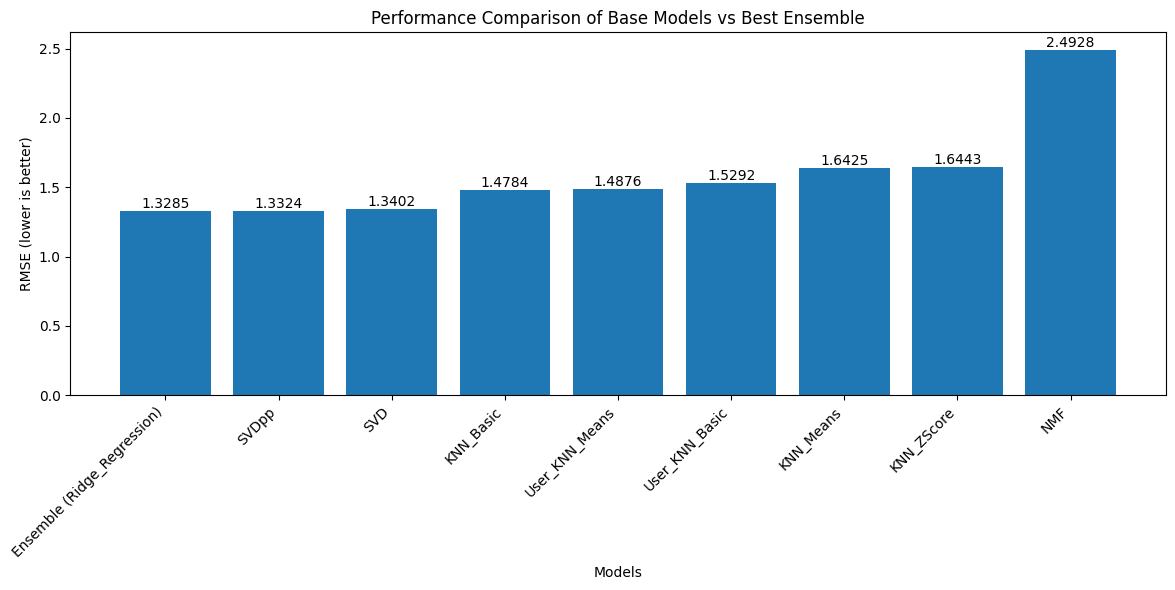

In [14]:
# Compare performance of individual models and ensemble
def plot_model_comparison(all_predictions, final_predictions, best_meta_name):
    model_rmse = {}
    print("Calculating RMSE for base models...")
    # Use only models that successfully produced predictions
    valid_base_predictions = {name: preds for name, preds in all_predictions.items() if preds}
    
    if not valid_base_predictions:
        print("No valid base model predictions found for comparison.")
    else:
        for name, predictions in valid_base_predictions.items():
            try:
                 model_rmse[name] = accuracy.rmse(predictions, verbose=False)
            except Exception as e:
                 print(f"Warning: Could not calculate RMSE for base model {name}: {e}")
                 model_rmse[name] = float('inf') # Assign infinity if RMSE calculation fails
    
    # Add ensemble RMSE if predictions were generated and a best model was found
    if final_predictions and best_meta_name:
        print("Calculating RMSE for ensemble model...")
        try:
            ensemble_rmse = accuracy.rmse(final_predictions, verbose=False)
            ensemble_key = f'Ensemble ({best_meta_name})'
            model_rmse[ensemble_key] = ensemble_rmse
            print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
        except Exception as e:
            print(f"Could not calculate ensemble RMSE: {e}")
            # Optionally add with inf RMSE if calculation fails
            # model_rmse[f'Ensemble ({best_meta_name})'] = float('inf') 
    elif not final_predictions:
        print("Warning: No final ensemble predictions available for comparison.")
    elif not best_meta_name:
         print("Warning: No best meta model identified for ensemble comparison.")

    # Filter out models with infinite RMSE before sorting/plotting
    valid_rmse = {k: v for k, v in model_rmse.items() if v != float('inf')}
    
    if not valid_rmse:
        print("No valid RMSE scores to plot.")
        return
        
    # Sort by RMSE
    sorted_rmse = {k: v for k, v in sorted(valid_rmse.items(), key=lambda item: item[1])}
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_rmse.keys(), sorted_rmse.values())
    plt.xlabel('Models')
    plt.ylabel('RMSE (lower is better)')
    plt.title('Performance Comparison of Base Models vs Best Ensemble')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()

# Plot model comparison (check if variables exist)
if 'all_predictions' in locals() and 'final_predictions' in locals() and 'best_meta_model_name' in locals():
    # Ensure best_meta_model_name is not None before plotting
    if best_meta_model_name:
        plot_model_comparison(all_predictions, final_predictions, best_meta_model_name)
    else:
        print("Skipping plot: Best meta model name not determined.")
else:
    print("Skipping plot: Required variables (all_predictions, final_predictions, best_meta_model_name) not defined.")

In [15]:
# Save the trained models for future use
def save_models(base_models_dict, meta_model_name, meta_results_dict):
    # Check if inputs are valid
    if not base_models_dict:
        print("Skipping model saving: Base models dictionary is empty.")
        return
    if not meta_model_name:
        print("Skipping model saving: Best meta model name not provided.")
        return
    if not meta_results_dict:
         print("Skipping model saving: Meta results dictionary is empty.")
         return
         
    print("Saving trained models...")
    
    # Create models directory if it doesn't exist
    import os
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save base models (only those that were successfully trained)
    for name, model in base_models_dict.items():
        if model is not None: # Check if model object exists
            try:
                with open(f'models/{name}_model.pkl', 'wb') as f:
                    pickle.dump(model, f)
            except Exception as e:
                 print(f"Error saving base model {name}: {e}")
        else:
             print(f"Skipping saving base model {name} as it was not trained successfully.")
    
    # Save the best meta model if it exists in results
    if meta_model_name in meta_results_dict:
        best_meta_model_info = meta_results_dict[meta_model_name]
        meta_model_obj = best_meta_model_info.get('model') # Use .get for safety

        # Check if the model object exists where expected
        if meta_model_obj is None and meta_model_name not in ['Simple_Average', 'Weighted_Average']:
             print(f"Warning: No trained model object found for meta-model {meta_model_name}. Skipping save.")
             return # Skip saving this meta-model

        try:
            if meta_model_name == 'Simple_Average':
                print("Simple_Average is computed on the fly, not saved as a file.")
            elif meta_model_name == 'Weighted_Average':
                # Save the weights dictionary if it exists
                if isinstance(meta_model_obj, dict):
                    with open(f'models/meta_{meta_model_name}_weights.pkl', 'wb') as f:
                        pickle.dump(meta_model_obj, f) # meta_model_obj is the weights dict
                    print(f"Meta-model {meta_model_name} weights saved successfully!")
                else:
                    print(f"Warning: Weights for {meta_model_name} not found or not a dictionary. Skipping save.")
            elif meta_model_name == 'Neural_Network':
                 # Check if NN model exists and is the correct type
                 if cuda_available and isinstance(meta_model_obj, torch.nn.Module):
                    # For PyTorch model, save state dict
                    torch.save(meta_model_obj.state_dict(), f'models/meta_{meta_model_name}_model.pt') # meta_model_obj is the NN model
                    print(f"Meta-model {meta_model_name} saved successfully!")
                 else:
                    print("Skipping saving Neural Network model (not available, not trained, or wrong type).")
            else: # Sklearn models
                # Check if it's a fitted sklearn model (basic check)
                if hasattr(meta_model_obj, 'predict'): 
                    with open(f'models/meta_{meta_model_name}_model.pkl', 'wb') as f:
                        pickle.dump(meta_model_obj, f) # meta_model_obj is the sklearn model
                    print(f"Meta-model {meta_model_name} saved successfully!")
                else:
                     print(f"Warning: Object for {meta_model_name} doesn't seem like a fitted sklearn model. Skipping save.")
        except Exception as e:
            print(f"Error saving meta-model {meta_model_name}: {e}")
    else:
        print(f"Warning: Best meta-model '{meta_model_name}' not found in results. Cannot save.")

# Save models (using the trained base models and the best meta model)
if 'all_models' in locals() and 'best_meta_model_name' in locals() and 'meta_results' in locals():
    # Ensure best_meta_model_name is not None before saving
    if best_meta_model_name:
        save_models(all_models, best_meta_model_name, meta_results)
    else:
        print("Skipping model saving: Best meta model name not determined.")
else:
    print("Skipping model saving: required variables (all_models, best_meta_model_name, meta_results) not defined.")

Saving trained models...
Meta-model Ridge_Regression saved successfully!
